# Classifiers

In order to run this notebook you must have installed some packages.  See [requirements](requirements.txt).  
File produced by running `conda list --export > requirements.txt`


Reference: 
* [Multi-Label Text Classification by Zuzanna Deutschman](https://towardsdatascience.com/multi-label-text-classification-5c505fdedca8).
* [Multi-label Classification Examples](https://skml.readthedocs.io/en/latest/auto_examples/index.html)

## Setting up libraries

### Importing py modules

In [89]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
# import nltk
# nltk.download('stopwords')

# from nltk.corpus import stopwords
# from nltk.stem.snowball import SnowballStemmer
# from bs4 import BeautifulSoup
# import lxml

import re
# import csv
# from tqdm import tqdm
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import BernoulliNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
# from sklearn.preprocessing import MultiLabelBinarizer
# import pickle


## Loading the data

In [90]:
tweets_new = pd.read_csv('tweets.csv')
# tweets_new

In [91]:
tweets = tweets_new.copy()
tweets.head(10)

,text_y,circumstantial-information,electricity,gas,gasoline,social-report,twitter-account,water
0,#1abr en foto la fuerte cola que se re...,2,0,0,2,1,0,0
1,#22nov #guayana alta vista los olivos ...,2,1,0,0,0,0,0
2,#28dic #singasolina #ciudadguayana deberi...,4,0,0,1,2,0,0
3,#ahora estaciones esperando por la cister...,4,0,0,2,0,0,0
4,#carabobo #singasolina imposible salir en ...,1,0,0,1,1,0,0
5,#denuncia en varias parroquias del oeste ...,1,0,0,2,3,0,0
6,#singasolina@dmurolo la cola llega al km1...,1,0,0,2,1,0,0
7,#sinluz #lacabagna #laboyera #elhatillo @e...,2,1,0,0,0,0,0
8,#sinluz esta usted y su falla debe ser ...,0,2,0,0,2,0,0
9,#sinluz los caobos sabana grande la ...,2,1,0,0,0,0,0


In [92]:
# print(tweets.columns.values)

# get the name of the columns: text and labels
TEXT_DESCRIPTION_COL = tweets.columns.values[0]
CIRCUMSTANTIAL_DESCRIPTION_COL = tweets.columns.values[1]
ELECTRICITY_DESCRIPTION_COL = tweets.columns.values[2]
GAS_DESCRIPTION_COL = tweets.columns.values[3]
GASOLINE_DESCRIPTION_COL = tweets.columns.values[4]
SOCIAL_DESCRIPTION_COL = tweets.columns.values[5]
ACCOUNT_DESCRIPTION_COL = tweets.columns.values[6]
WATER_DESCRIPTION_COL = tweets.columns.values[7]
print('Column names:')
print('\t' ,TEXT_DESCRIPTION_COL)
print('\t' ,CIRCUMSTANTIAL_DESCRIPTION_COL)
print('\t' ,ELECTRICITY_DESCRIPTION_COL)
print('\t' ,GAS_DESCRIPTION_COL)
print('\t' ,GASOLINE_DESCRIPTION_COL)
print('\t' ,SOCIAL_DESCRIPTION_COL)
print('\t' ,ACCOUNT_DESCRIPTION_COL)
print('\t' ,WATER_DESCRIPTION_COL)

Column names:
	 text_y
	 circumstantial-information
	 electricity
	 gas
	 gasoline
	 social-report
	 twitter-account
	 water


In [93]:
tc = tweets.copy()

# isolate the text and the labels
tc_labels = tc.drop(labels=[TEXT_DESCRIPTION_COL], axis=1)
tc_text = tc.drop(labels=[CIRCUMSTANTIAL_DESCRIPTION_COL,
                          ELECTRICITY_DESCRIPTION_COL, GAS_DESCRIPTION_COL,
                          GASOLINE_DESCRIPTION_COL, SOCIAL_DESCRIPTION_COL,
                          ACCOUNT_DESCRIPTION_COL, WATER_DESCRIPTION_COL], axis=1)

# replaces any number greater than 0 for a 1, bc we need "existance" or "not existance" of the
# label on the tweet
tc_labels = tc_labels.where(tc_labels == 0, 1)
tc_labels.head(10)

,circumstantial-information,electricity,gas,gasoline,social-report,twitter-account,water
0,1,0,0,1,1,0,0
1,1,1,0,0,0,0,0
2,1,0,0,1,1,0,0
3,1,0,0,1,0,0,0
4,1,0,0,1,1,0,0
5,1,0,0,1,1,0,0
6,1,0,0,1,1,0,0
7,1,1,0,0,0,0,0
8,0,1,0,0,1,0,0
9,1,1,0,0,0,0,0


In [94]:
binarized_tweet_labels = tc_text.merge(tc_labels, on=tc_labels.index)  # in case I need to merge them
binarized_tweet_labels = binarized_tweet_labels.drop(labels = ['key_0'], axis=1)
binarized_tweet_labels.head(10)

,text_y,circumstantial-information,electricity,gas,gasoline,social-report,twitter-account,water
0,#1abr en foto la fuerte cola que se re...,1,0,0,1,1,0,0
1,#22nov #guayana alta vista los olivos ...,1,1,0,0,0,0,0
2,#28dic #singasolina #ciudadguayana deberi...,1,0,0,1,1,0,0
3,#ahora estaciones esperando por la cister...,1,0,0,1,0,0,0
4,#carabobo #singasolina imposible salir en ...,1,0,0,1,1,0,0
5,#denuncia en varias parroquias del oeste ...,1,0,0,1,1,0,0
6,#singasolina@dmurolo la cola llega al km1...,1,0,0,1,1,0,0
7,#sinluz #lacabagna #laboyera #elhatillo @e...,1,1,0,0,0,0,0
8,#sinluz esta usted y su falla debe ser ...,0,1,0,0,1,0,0
9,#sinluz los caobos sabana grande la ...,1,1,0,0,0,0,0


## Vectorizing

In [95]:
# spliting the data into train and test
train, test = train_test_split(binarized_tweet_labels, random_state=42, test_size=0.30, shuffle=True)
train_text = train[TEXT_DESCRIPTION_COL].values.astype('U')
test_text = test[TEXT_DESCRIPTION_COL].values.astype('U')


# creating the vectorizer, using uni-bi-tri grams, and selecting only 10000 features.
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', 
                             ngram_range=(1,3), norm='l2', max_features = 10000)

vectorizer.fit(train_text)
vectorizer.fit(test_text)

# x_train is the vectorization of each document - sparse matrix
x_train = vectorizer.transform(train_text)

# y_train are the corresponding labels of each document - pandas.DF
y_train = train.drop(labels = [TEXT_DESCRIPTION_COL], axis=1)

# same as above, but whit will be used for testing
x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = [TEXT_DESCRIPTION_COL], axis=1)


In [96]:
x_train

<28x423 sparse matrix of type '<class 'numpy.float64'>'
	with 202 stored elements in Compressed Sparse Row format>

#### Explore . . .

In [97]:
# features selected by the vectorizer with uni-bi-tri grams
# x_train
features = vectorizer.get_feature_names()
features

['07',
 '07 10',
 '07 10 pm',
 '10',
 '10 de',
 '10 de abril',
 '10 pm',
 '10 pm nomasracionamiento',
 '12',
 '12 25',
 '12 25 pm',
 '25',
 '25 pm',
 '2pm',
 '2pm sinluz',
 '2pm sinluz tachira',
 'abril',
 'abril sinluz',
 'abril sinluz video',
 'agua',
 'agua potable',
 'agua potable venezuela',
 'aguantar',
 'aguantar el',
 'aguantar el coronavirusvenezuela',
 'ahora',
 'ahora para',
 'ahora para variar',
 'al',
 'al km18',
 'al km18 pnm',
 'alimentos',
 'alimentos agua',
 'alimentos agua potable',
 'apagon',
 'apagon este',
 'apagon este se',
 'asi',
 'asi desalojan',
 'asi desalojan el',
 'asi tenemos',
 'asi tenemos que',
 'atentos',
 'atentos sus',
 'atentos sus gestiones',
 'bello',
 'bello monte',
 'bello monte sinluz',
 'bomba',
 'bomba gasolina',
 'buenas',
 'buenas tardes',
 'buenas tardes corpoelecinfo',
 'buscar',
 'buscar alimentos',
 'buscar alimentos agua',
 'campigna',
 'campigna se',
 'campigna se fue',
 'caobos',
 'caobos sabana',
 'caobos sabana grande',
 'carabobo'

## Build a model, train and predict

Helper methods to evaluate the model

In [98]:
def report_measures(y_test, y_pred) -> None:

    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Hamming loss: ", hamming_loss(y_test, y_pred))
    
    print("F1 score:")
    print("\tmicro: ", f1_score(y_test, y_pred, average='micro'))
    print("\tmacro: ", f1_score(y_test, y_pred, average='macro'))

    print("Precision:")
    print("\tmicro: ", precision_score(y_test, y_pred, average='micro'))
    print("\tmacro: ", precision_score(y_test, y_pred, average='macro'))

    print("Recall:")
    print("\tmicro: ", recall_score(y_test, y_pred, average='micro'))
    print("\tmacro: ", recall_score(y_test, y_pred, average='macro'))

### Binary Relevance
1. with GaussianNB

In [99]:
#Binary Relevance: Naive Bayes with Bernoulli Distribution
br_classifier = BinaryRelevance(BernoulliNB())
br_classifier.fit(x_train, y_train)
br_predictions = br_classifier.predict(x_test)

report_measures(y_test, br_predictions)

Accuracy:  0.25
Hamming loss:  0.4166666666666667
F1 score:
	micro:  0.5070422535211268
	macro:  0.3736263736263736
Precision:
	micro:  0.46153846153846156
	macro:  0.41666666666666663
Recall:
	micro:  0.5625
	macro:  0.3816326530612245


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2. with LogisticRegression

In [100]:
# Binary Relevance: Logistic Regression
br_classifier1 = BinaryRelevance(LogisticRegression())
br_classifier1.fit(x_train, y_train)
br_predictions1 = br_classifier1.predict(x_test)

report_measures(y_test, br_predictions1)

# br_predictions.toarray()
# y_test

Accuracy:  0.25
Hamming loss:  0.15476190476190477
F1 score:
	micro:  0.8115942028985507
	macro:  0.43643198906356806
Precision:
	micro:  0.7567567567567568
	macro:  0.46428571428571436
Recall:
	micro:  0.875
	macro:  0.4761904761904762


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

### Label Powerset


In [101]:
#Label Powerset
lp_classifier = LabelPowerset(LogisticRegression())
lp_classifier.fit(x_train, y_train)
lp_predictions = lp_classifier.predict(x_test)

report_measures(y_test, lp_predictions)

Accuracy:  0.4166666666666667
Hamming loss:  0.15476190476190477
F1 score:
	micro:  0.7719298245614036
	macro:  0.3730674087816945
Precision:
	micro:  0.88
	macro:  0.5346320346320346
Recall:
	micro:  0.6875
	macro:  0.35374149659863946


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

### MLkNN

In [102]:
ml_classifier = MLkNN(k=4)
# to prevent errors when handling sparse matrices.
x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(x_test).toarray()

ml_classifier.fit(x_train, y_train)
ml_predictions = ml_classifier.predict(x_test)

report_measures(y_test, ml_predictions)

Accuracy:  0.5
Hamming loss:  0.10714285714285714
F1 score:
	micro:  0.8615384615384615
	macro:  0.5951762523191094
Precision:
	micro:  0.8484848484848485
	macro:  0.569047619047619
Recall:
	micro:  0.875
	macro:  0.6591836734693877


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_neighbors=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7

### Classifier Chain Model

In [103]:
# for the next classifier we need to remove from y-train, y-test categories which
# equal 0 for all train samples
# y_train = train.drop(labels = [TEXT_DESCRIPTION_COL], axis=1)
# y_test = test.drop(labels = [TEXT_DESCRIPTION_COL], axis=1)
# selected_labels = y_train.columns[y_train.sum(axis = 0, skipna = True) > 0].tolist()

# y_train = y_train.filter(selected_labels, axis=1)
# y_test = y_test.filter(selected_labels, axis=1)
# x_train = vectorizer.transform(train_text)
# x_test = vectorizer.transform(test_text)

cc_classifier = ClassifierChain(LogisticRegression())
cc_classifier.fit(x_train, y_train)
# print(cc_classifier.predict(x_test))
cc_predictions_proba = cc_classifier.predict_proba(x_test)

report_measures(y_test, cc_classifier.predict(x_test))

Accuracy:  0.4166666666666667
Hamming loss:  0.13095238095238096
F1 score:
	micro:  0.8253968253968254
	macro:  0.3821892393320964
Precision:
	micro:  0.8387096774193549
	macro:  0.36054421768707484
Recall:
	micro:  0.8125
	macro:  0.40816326530612246


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len

t = 0.05 	 Accuracy =  0.0 	 F1 =  0.5871559633027523 	 Hamming loss =  0.5357142857142857
t = 0.06 	 Accuracy =  0.0 	 F1 =  0.5961538461538461 	 Hamming loss =  0.5
t = 0.07 	 Accuracy =  0.0 	 F1 =  0.5961538461538461 	 Hamming loss =  0.5
t = 0.08 	 Accuracy =  0.0 	 F1 =  0.5961538461538461 	 Hamming loss =  0.5
t = 0.09 	 Accuracy =  0.0 	 F1 =  0.5961538461538461 	 Hamming loss =  0.5
t = 0.1 	 Accuracy =  0.0 	 F1 =  0.5961538461538461 	 Hamming loss =  0.5
t = 0.11 	 Accuracy =  0.0 	 F1 =  0.5961538461538461 	 Hamming loss =  0.5
t = 0.12 	 Accuracy =  0.0 	 F1 =  0.6262626262626263 	 Hamming loss =  0.44047619047619047
t = 0.13 	 Accuracy =  0.0 	 F1 =  0.6326530612244898 	 Hamming loss =  0.42857142857142855
t = 0.14 	 Accuracy =  0.0 	 F1 =  0.6595744680851063 	 Hamming loss =  0.38095238095238093
t = 0.15 	 Accuracy =  0.0 	 F1 =  0.6976744186046512 	 Hamming loss =  0.30952380952380953
t = 0.16 	 Accuracy =  0.0 	 F1 =  0.7228915662650602 	 Hamming loss =  0.273809523809

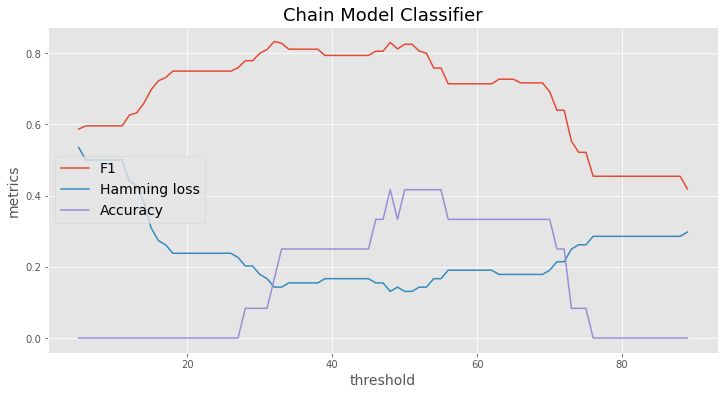

In [104]:
#for plotting metrics as a function of threashold
def plotting_metrics_function_of_threshold(model_name, cc_predictions_proba, y_test):
    th = []
    f = []
    ham = []
    ac = []

    for t in range (5,90): # threshold value
        y_pred_new = (cc_predictions_proba >= t/100).astype(int)
        print("t =" ,t/100, '\t', "Accuracy = ",accuracy_score(y_test,y_pred_new),
             '\t', "F1 = ",f1_score(y_test,y_pred_new, average="micro"), '\t',
              "Hamming loss = ",hamming_loss(y_test,y_pred_new))
        th.append(t)
        ac.append(accuracy_score(y_test,y_pred_new))
        f.append(f1_score(y_test,y_pred_new, average="micro"))
        ham.append(hamming_loss(y_test,y_pred_new))
    plt.rcParams["figure.figsize"] = (12,6)
    with plt.style.context('ggplot'):
        plt.plot(th, f)
        plt.plot(th, ham)
        plt.plot(th, ac)
        plt.legend(['F1', 'Hamming loss', 'Accuracy'], loc='center left', fontsize = 14)
        plt.ylabel("metrics", fontsize = 14)
        plt.xlabel("threshold", fontsize = 14)
        plt.title(model_name, fontsize = 18)
    plt.show()
    
plotting_metrics_function_of_threshold('Chain Model Classifier', cc_predictions_proba, y_test)

### multi label Classifier using Neural Networks

Two ways to do this:
* using TF-IDF Vectorizer
* using Word Embeddings

In [105]:
import tensorflow as tf
from tensorflow import keras

#### using TF-IDF vectorizer
For this model we will use TF-IDF vectorizer generated on [Section 1.3](#Vectorizing) to convert the sentences into vectors, then this will be passed
into the neural network.

In [106]:
# print(x_train.shape[1])
# x_train
# y_train
# x_test
# y_test

# work to be done. . .

model = keras.Sequential()
model.add(keras.layers.Dense(16, input_dim=x_train.shape[1], activation="relu"))
# model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(tweets.columns.values.shape[0] -1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                6784      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 119       
Total params: 6,903
Trainable params: 6,903
Non-trainable params: 0
_________________________________________________________________


In [107]:


model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

batch_size = 20
epochs = 10

history = model.fit(x_train, y_train, batch_size, epochs, validation_data=(x_test, y_test))

results = model.evaluate(x_test, y_test, batch_size)

nn_predictions = model.predict(x_test)

Train on 28 samples, validate on 12 samples
Epoch 1/10
28/28 [==============================] - 0s 7ms/sample - loss: 0.6935 - acc: 0.4643 - val_loss: 0.6868 - val_acc: 0.5357
Epoch 2/10
28/28 [==============================] - 0s 212us/sample - loss: 0.6913 - acc: 0.5153 - val_loss: 0.6853 - val_acc: 0.5833
Epoch 3/10
28/28 [==============================] - 0s 150us/sample - loss: 0.6893 - acc: 0.5306 - val_loss: 0.6839 - val_acc: 0.5952
Epoch 4/10
28/28 [==============================] - 0s 151us/sample - loss: 0.6872 - acc: 0.5561 - val_loss: 0.6825 - val_acc: 0.6071
Epoch 5/10
28/28 [==============================] - 0s 164us/sample - loss: 0.6854 - acc: 0.5867 - val_loss: 0.6811 - val_acc: 0.6071
Epoch 6/10
28/28 [==============================] - 0s 150us/sample - loss: 0.6834 - acc: 0.6276 - val_loss: 0.6798 - val_acc: 0.6429
Epoch 7/10
28/28 [==============================] - 0s 137us/sample - loss: 0.6816 - acc: 0.6582 - val_loss: 0.6784 - val_acc: 0.6667
Epoch 8/10
28/28 [==

In [114]:
# print(history)
print(results)
# nn_predictions
# plotting_metrics_function_of_threshold('ANN Classifier', nn_predictions, y_test)


[0.6742768287658691, 0.7380953]


In [115]:
pd_pred_prob = pd.DataFrame(nn_predictions, columns = tweets.columns.values[1:])
pd_pred = (pd_pred_prob.copy() >= 0.5)
pd_pred = pd_pred.where(pd_pred == True, 0)
pd_pred = pd_pred.where(pd_pred == False, 1)

report_measures(y_test, pd_pred.to_numpy(dtype=np.int))

Accuracy:  0.08333333333333333
Hamming loss:  0.2619047619047619
F1 score:
	micro:  0.717948717948718
	macro:  0.49398577612863326
Precision:
	micro:  0.6086956521739131
	macro:  0.4354256854256854
Recall:
	micro:  0.875
	macro:  0.6258503401360545


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
# pd_pred.insert(0, 'tweet', test_text)
# pd_pred

In [111]:
tw_doc = 'La cosa esta dificil con lo de la luz y todo lo demas'
tw_doc_vector = vectorizer.transform([tw_doc])

tw_pred = model.predict([tw_doc_vector])
print('Prediction: \n', tw_doc)
pd.DataFrame(tw_pred, columns = tweets.columns.values[1:])

Prediction: 
 La cosa esta dificil con lo de la luz y todo lo demas


,circumstantial-information,electricity,gas,gasoline,social-report,twitter-account,water
0,0.514446,0.518761,0.50222,0.494843,0.513713,0.496465,0.475611


#### using Word Embeddings

TBD

In [112]:
# binarized_tweet_labels

#  these are all the labels, for now I will select only one of them
#  and we will test the classification on a single label.

# print( TEXT_DESCRIPTION_COL )
# print( CIRCUMSTANTIAL_DESCRIPTION_COL )
# print( ELECTRICITY_DESCRIPTION_COL )
# print( GAS_DESCRIPTION_COL )
# print( GASOLINE_DESCRIPTION_COL )
# print( SOCIAL_DESCRIPTION_COL )
# print( ACCOUNT_DESCRIPTION_COL )
# print( WATER_DESCRIPTION_COL )

